In [45]:
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import rioxarray as rxr
import xarray as xr
import xesmf as xe
import pandas as pd

In [46]:
date = input("Enter date (YYYY-MM-DD): ")
init_hour = int(input("Enter initialization hour (HH): "))
forecast = int(input("Enter forecast hour (0...18 for off-hour HRRR runs & 48 for long-range runs): "))

# Build the HRRR cycle datetime (initialization time)
cycle_dt = datetime.fromisoformat(f"{date} {init_hour:02d}:00")

# Compute the forecast valid time (handles day/month/year rollovers)
valid_dt = cycle_dt + timedelta(hours=forecast)

# Optional: a display string if you need it
displayhour = valid_dt.strftime("%H:%M")

# Compute display hour safely
displayhour = (forecast + init_hour) % 24

# HRRR: pass the cycle time + forecast hour
hrrr = Herbie(
    cycle_dt,
    model="hrrr",
    product="sfc",
    fxx=forecast
)

# RTMA: pass the *valid* analysis time so it matches HRRR's valid time
rtma = Herbie(
    valid_dt,
    model="rtma",
    product="anl"
)

### Load into xarray dataarrays
ds_hrrr = hrrr.xarray("TMP:2 m above")
ds_rtma = rtma.xarray("TMP:2 m above")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Nov-13 00:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=rtma ┊ product=anl ┊ 2025-Nov-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/Users/john_b_needham/data/rtma/20251115]


In [47]:
# Curvilinear grids from your HRRR/RTMA Datasets
src_grid = {"lon": ds_rtma["longitude"], "lat": ds_rtma["latitude"]}
tgt_grid = {"lon": ds_hrrr["longitude"], "lat": ds_hrrr["latitude"]}

# Fast sanity first (nearest), then higher-quality bilinear — no filenames
regridder_fast = xe.Regridder(src_grid, tgt_grid, method="nearest_s2d",
                              periodic=True, reuse_weights=False)
rtma_on_hrrr_fast = regridder_fast(ds_rtma["t2m"])

###regridder_bilin = xe.Regridder(src_grid, tgt_grid, method="bilinear",
###                               periodic=True, reuse_weights=False)
###rtma_on_hrrr = regridder_bilin(ds_rtma["t2m"])

tempdiffF = (ds_hrrr["t2m"] - rtma_on_hrrr_fast) * 9/5
print(float(np.abs(tempdiffF).quantile(0.95)))

6.295605659484863


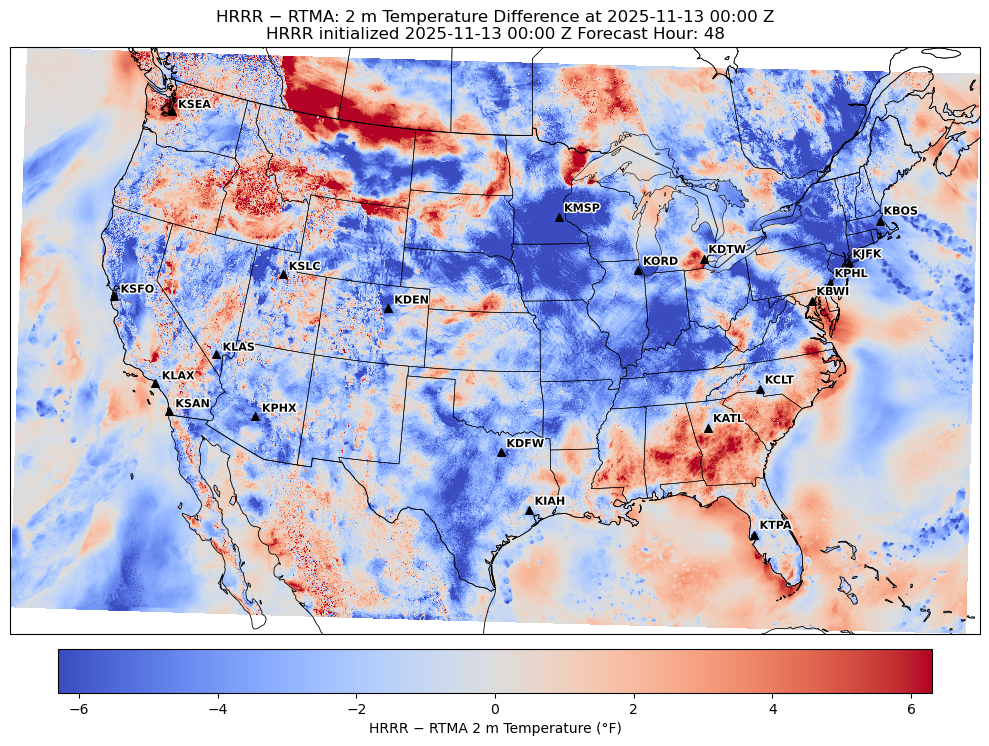

In [48]:
# 1) Use HRRR lon/lat and wrap to [-180, 180] (Cartopy expects this for PlateCarree)
lon = ds_hrrr["longitude"]
lat = ds_hrrr["latitude"]
lon = ((lon + 180) % 360) - 180  # robust wrap

# 2) Make sure tempdiffF matches lon/lat shape and mask bad cells
# (tempdiffF should be your (hrrr - rtma_on_hrrr) * 9/5 result)
T = tempdiffF.where(np.isfinite(tempdiffF))

# Pick symmetric color limits from percentiles (or keep fixed)
v = np.nanpercentile(np.abs(T.values), 95)
vmin, vmax = -v, v

# 3) Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-95))
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.4)

# Data are in geographic lon/lat, so transform from PlateCarree
pc = ccrs.PlateCarree()

# pcolormesh with curvilinear lon/lat; shading='nearest' treats lon/lat as cell centers
p = ax.pcolormesh(
    lon, lat, T,
    transform=pc,
    cmap="coolwarm",
    shading="nearest",
    vmin=vmin, vmax=vmax,
    rasterized=True,  # smaller vector PDF/SVG
)

cb = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.02, shrink=0.9)
cb.set_label("HRRR − RTMA 2 m Temperature (°F)")

# Build a descriptive title (adjust to your variables)
ax.set_title("HRRR − RTMA: 2 m Temperature Difference at " + date + " " + f"{displayhour:02d}:00 Z" + "\nHRRR initialized " + cycle_dt.strftime("%Y-%m-%d %H:%M Z") + f" Forecast Hour: {forecast}")

# Major CONUS city hubs (not exhaustive, but hits the big ones)
airports = pd.DataFrame([
    #  ICAO  City
    ("KATL","Atlanta",      33.6367, -84.4281),
    ("KLAX","Los Angeles",  33.9416,-118.4085),
    ("KORD","Chicago",      41.9742, -87.9073),
    ("KDFW","Dallas/FortW", 32.8968, -97.0379),
    ("KDEN","Denver",       39.8617,-104.6731),
    ("KJFK","New York",     40.6413, -73.7781),
    ("KSFO","San Francisco",37.6213,-122.3790),
    ("KSEA","Seattle",      47.4502,-122.3088),
    ("KLAS","Las Vegas",    36.0840,-115.1537),
    ("KCLT","Charlotte",    35.2140, -80.9431),
    ("KPHX","Phoenix",      33.4343, -112.0116),
    ("KIAH","Houston",      29.9902,  -95.3368),
    ("KBOS","Boston",       42.3656,  -71.0096),
    ("KMSP","Minneapolis",  44.8848,  -93.2223),
    ("KDTW","Detroit",      42.2124,  -83.3534),
    ("KPHL","Philadelphia", 39.8744,  -75.2424),
    ("KBWI","Baltimore",    39.1754,  -76.6684),
    ("KSLC","Salt Lake",    40.7899, -111.9791),
    ("KSAN","San Diego",    32.7338, -117.1933),
    ("KTPA","Tampa",        27.9755,  -82.5332),
], columns=["icao","city","lat","lon"])

pc = ccrs.PlateCarree()

def plot_airports(ax, df=airports):
    # points
    ax.scatter(df.lon, df.lat, transform=pc, marker="^", s=30, zorder=6, color="black")
    # labels with a small offset to avoid overlap with markers
    for _, r in df.iterrows():
        ax.text(
            r.lon + 0.35, r.lat + 0.25, r.icao,
            transform=pc, fontsize=8, fontweight="bold", zorder=7, color="black",
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]  # white halo for readability
        )

# Usage: after you’ve created `ax` and plotted your tempdiff
plot_airports(ax)

plt.tight_layout()
plt.show()
